In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.data import imread
from pathlib import Path

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission_v2.csv', 'test_v2', 'train_ship_segmentations_v2.csv', 'train_v2']


In [37]:
train = pd.read_csv('../input/train_ship_segmentations_v2.csv')
traincsv = pd.read_csv('../input/train_ship_segmentations_v2.csv')
train.head()


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


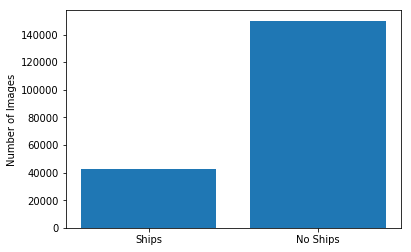

In [38]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Images');

#traincsv = pd.read_csv('../input/train_ship_segmentations_v2.csv')

> #### As you can see, the EncodedPixels are the ship location in the imgs. <br>For example, total pixels are 768*768 = 589824, in pic 2, 264661  17 means, from 264661 pixel to 264678 pixel are ship. This is for training data only. What we need to feed back is something like this.<br>Also, Nan means no ship in the image.

>#### Look at images with ships

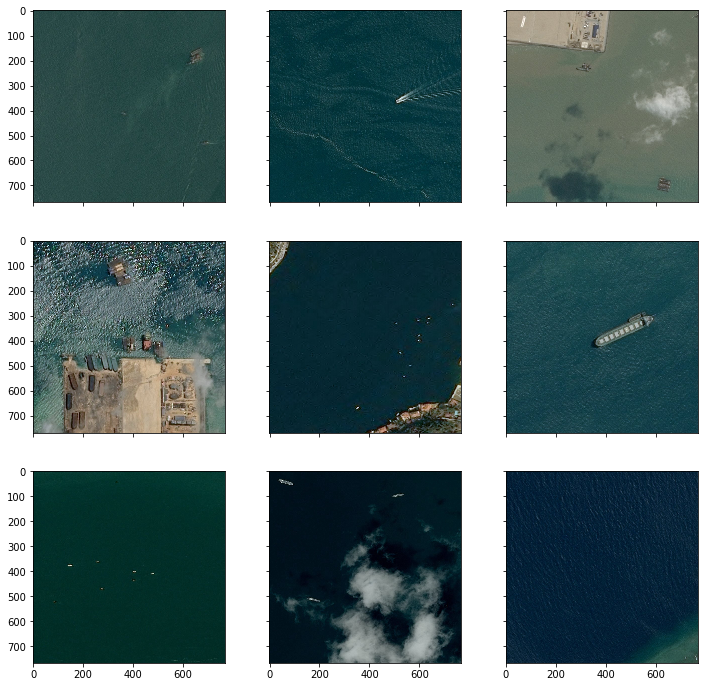

In [39]:
sample = train[~train.EncodedPixels.isna()].sample(9)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
fig.set_size_inches(12, 12)

for i, imgid in enumerate(sample.ImageId):
    col = i % 3
    row = i // 3
    
    path = Path('../input/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

>#### Look at images without ships

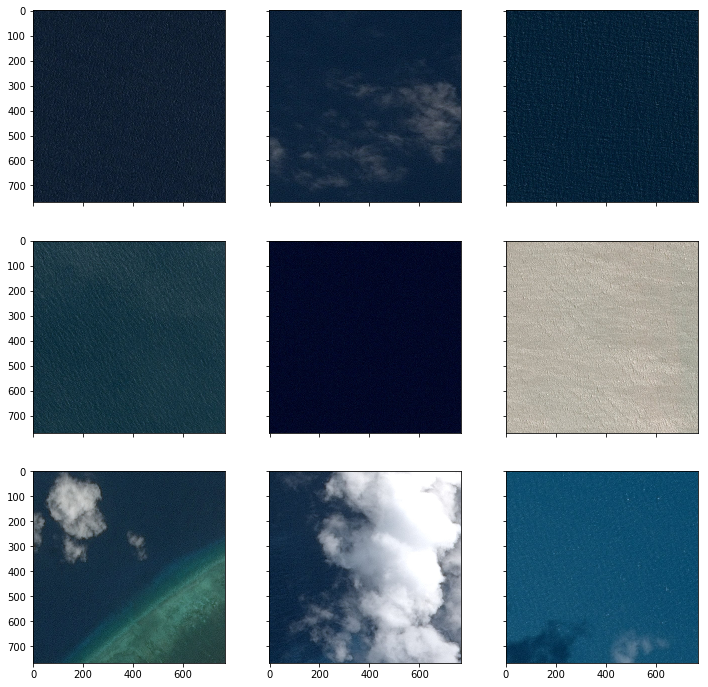

In [40]:
sample = train[train.EncodedPixels.isna()].sample(9)

fig, ax = plt.subplots(3, 3, sharex='col', sharey='row')
fig.set_size_inches(12, 12)

for i, imgid in enumerate(sample.ImageId):
    col = i % 3
    row = i // 3
    
    path = Path('../input/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

>#### Mask the training data with segmentations infomation.<br>1 - ship    0 - no ship

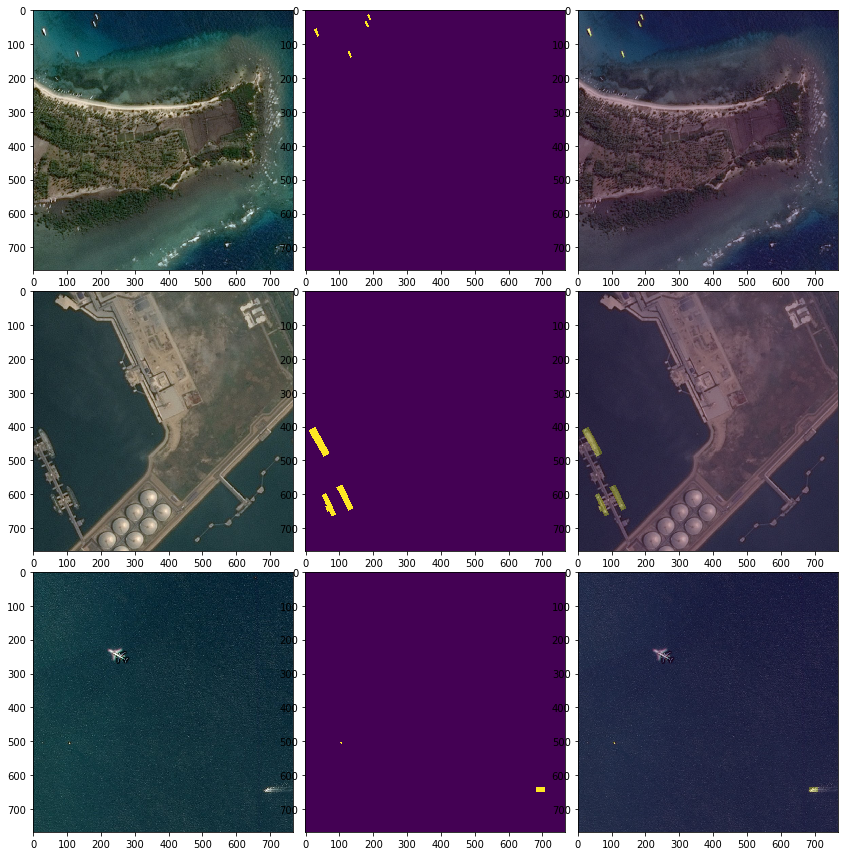

In [130]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    #s[::2] means
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
sample = train[~train.EncodedPixels.isna()].sample(3)

for i, image_id in enumerate(sample.ImageId):
    img = imread(f'../input/train_v2/{image_id}')
    mask_shape = img.shape[:-1]
    mask = np.zeros(mask_shape)
    
    encoded_pixels_list = traincsv[traincsv.ImageId == image_id].EncodedPixels.tolist()
    for encoded_pixels in encoded_pixels_list:
        mask += rle_decode(encoded_pixels, mask_shape)
        
    row = i // 1
    col = 0
    axes[row][col].axis('on')
    axes[row][col+1].axis('on')
    axes[row][col+2].axis('on')
    axes[row][col].imshow(img)
    axes[row][col+1].imshow(mask)
    axes[row][col+2].imshow(img)
    axes[row][col+2].imshow(mask,alpha=0.3)
    
plt.tight_layout(h_pad=0, w_pad=0)
fig.set_size_inches(12, 12)
plt.show()

>### Plot images with ships in mask and images with no-ships in mask


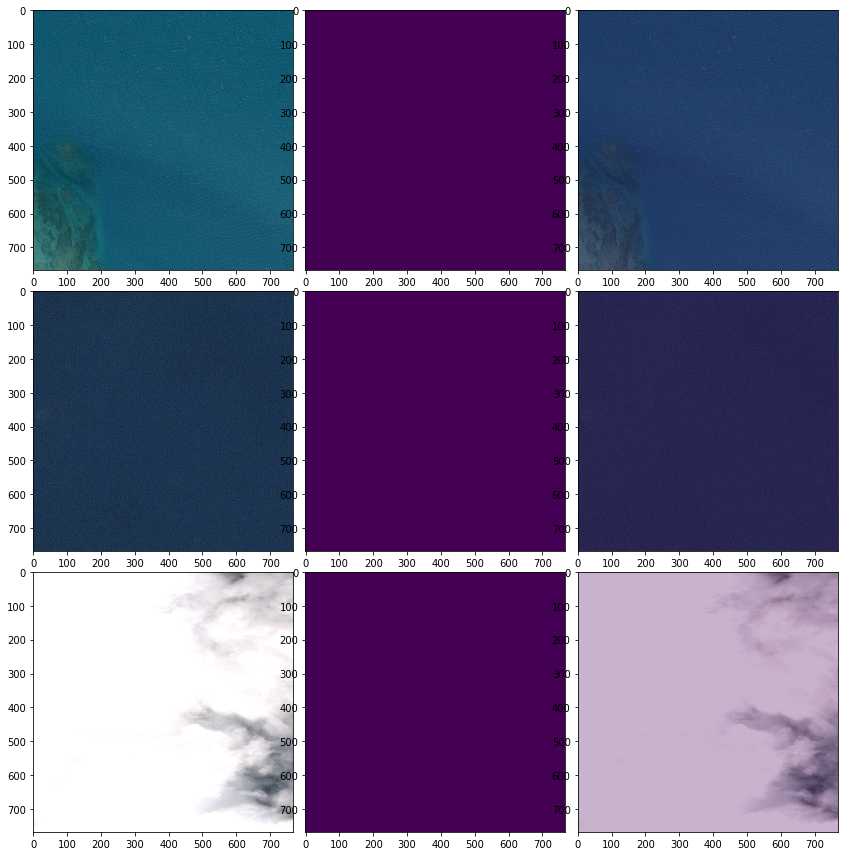

In [151]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
sample = train[train.EncodedPixels.isna()].sample(3)

for i, image_id in enumerate(sample.ImageId):
    img = imread(f'../input/train_v2/{image_id}')
    mask_shape = img.shape[:-1]
    mask = np.zeros(mask_shape)

    row = i // 1
    col = 0
    axes[row][col].axis('on')
    axes[row][col+1].axis('on')
    axes[row][col+2].axis('on')
    axes[row][col].imshow(img)
    axes[row][col+1].imshow(mask)
    axes[row][col+2].imshow(img)
    axes[row][col+2].imshow(mask,alpha=0.3)
    
plt.tight_layout(h_pad=0, w_pad=0)
fig.set_size_inches(12, 12)
plt.show()

>### Adjust the mask to make the background transparent

>### EncodedPixels size distribution

count    81723.000000
mean      1567.402849
std       2842.081203
min          2.000000
25%        111.000000
50%        408.000000
75%       1550.000000
max      25904.000000
Name: EncodedPixels, dtype: float64

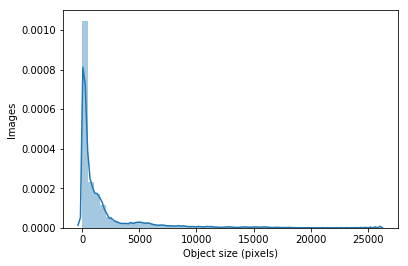

In [98]:
def rle_pixels(rle):
    """ returns: the pixel count in the object encoded by 'rle' """
    if rle.size > 0:
        return np.sum(rle[:,1])
    return 0

def encodedpixels2rle(encodedpixels):
    if isinstance(encodedpixels, str):
        return np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    return np.array([])

def object_pixels(encodedpixels):
    """ returns: the number of pixels in the object encoded by 'encodedpixels' """
    return rle_pixels(encodedpixels2rle(encodedpixels))

obj_pixels = traincsv.dropna().EncodedPixels.map(lambda x: object_pixels(x))


sns.distplot(obj_pixels, kde=True)
plt.xlabel('Object size (pixels)');
plt.ylabel('Images');

obj_pixels.describe()

>### Ship numbers distribution after dropping noship images

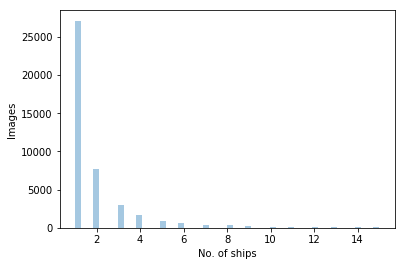

In [100]:
id_images_obj = traincsv.dropna().groupby('ImageId').count()
id_images_obj.rename({'EncodedPixels': 'ObjCount'}, axis='columns', inplace=True)
ships = id_images_obj.ObjCount.sum()
#id_images_obj.ObjCount.hist(bins=15)
sns.distplot(id_images_obj.ObjCount, kde=False)
plt.xlabel('No. of ships');
plt.ylabel('Images');